In [5]:
import pandas as pd
import tensorflow 
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
import re
import sklearn
from sklearn.model_selection import train_test_split
import tqdm
from gensim.models import Word2Vec
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import make_pipeline
from tensorflow.keras import datasets,models,layers
from tensorflow.keras.layers import Conv1D, Concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, Dense, Embedding, Input,BatchNormalization
from tensorflow.keras.models import Model
import seaborn as sns


In [6]:
df = pd.read_csv('data - data.csv').drop(columns=['Unnamed: 3'])
df.shape

(31460, 3)

In [7]:
df = df[df['rate'] != 3]
df
'''
Loại những giá trị ở cột column có giá trị = 3
'''

'\nLoại những giá trị ở cột column có giá trị = 3\n'

In [8]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating <= 2:
        return 0
    else:
        return 1

# Apply to the dataset 
df['sentiment'] = df.rate.apply(to_sentiment)
'''
Apply hàm to_sentiment để xử lý giá trị của data cột rate
'''

'\nApply hàm to_sentiment để xử lý giá trị của data cột rate\n'

In [9]:
df

,comment,label,rate,sentiment
0,Áo bao đẹp ạ!!,POS,5,1
1,Tuyệt vời !,POS,5,1
2,2day ao khong giong trong.,NEG,1,0
3,"Mùi thơm,bôi lên da mềm da.",POS,5,1
4,"Vải đẹp, dày dặn.",POS,5,1
...,...,...,...,...
31455,Không đáng tiền.,NEG,1,0
31456,Quần rất đẹp.,POS,5,1
31457,Hàng đẹp đúng giá tiền.,POS,5,1
31458,Chất vải khá ổn.,POS,4,1


c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'review sentiment')

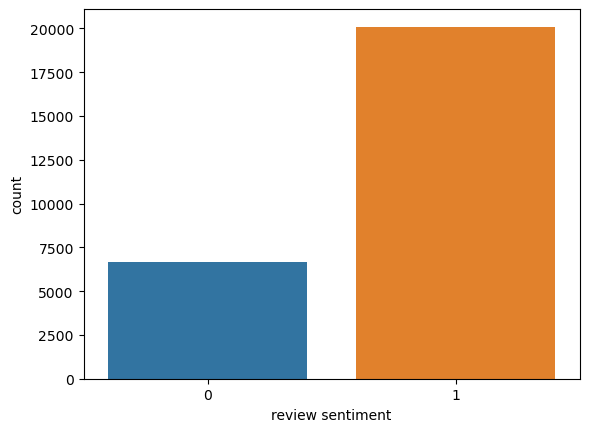

In [10]:
# # Plot the distribution
class_names = ['negative', 'positive']
'''
- Tạo 2 class: Negative n Positive
'''
sns.countplot( x='sentiment',data = df)
plt.xlabel('review sentiment')
# ax.set_xticklabels(class_names)

In [11]:
df['sentiment'].value_counts() # Đếm tổng giá trị mỗi class trong cột sentiment

sentiment
1    20093
0     6669
Name: count, dtype: int64

In [12]:
from sklearn.utils import resample

df_majority = df[(df['sentiment'] == 1)]
df_minority = df[(df['sentiment'] == 0)]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=20093, # to match majority class
                                 random_state=42)

df1 = pd.concat([df_minority_upsampled, df_majority])
''' 
- Xử lý unbalanced data bằng cách over sampling
'''


' \n- Xử lý unbalanced data bằng cách over sampling\n'

In [13]:
df1['sentiment'].value_counts() # Kết quả sau khi xử lý unbalanced data

sentiment
0    20093
1    20093
Name: count, dtype: int64

In [ ]:
X = df1['comment']
y = df1['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print("Train Data size:", len(X_train), len(y_train))
print("Test Data size", len(X_test), len(y_test))

''' 
Chia tập train và tập test
'''

In [15]:
tokenizer = Tokenizer() # Tokenizer is used to vectorize a text corpus by turning each text into a sequence of integers
tokenizer.fit_on_texts(X_train)
'''
- fit_on_texts method updates the internal vocabulary based on the list of texts 
- It creates a word index, where each unique word in the training set is assigned a unique integer.
'''

# Convert text to sequences of integers
X_train = tokenizer.texts_to_sequences(X_train)
'''
- Converts each text in the training set (X_train) into a sequence of integers
- Each word in the text is replaced by its corresponding integer from the word index.
'''
X_test = tokenizer.texts_to_sequences(X_test)
'''
- Similar to X_train
'''

In [16]:
max_length = max([len(seq) for seq in X_train]) # Calculate max length of sequences in X_train
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
'''
- pad the sequences in X_train to the same length (max_length)
- typically done by adding zeros at the beginning or end of the sequences to make them all the same length.
'''
print(f"After padding: {X_train.shape}")
print(f"After padding:{X_test.shape}") # Print Shapes of Padded Sequences

After padding: (32148, 77)
After padding:(8038, 77)


In [17]:
batch_size=512 # the model will process 512 samples before updating the model parameters
vocab_size = len(tokenizer.word_index)+1
'''
- Total number of unique words in the tokenizer’s word index
- +1 is added to account for the padding token
- Used to define the size of the input layer in embedding layers or other layers that need to know the number of unique tokens.
'''
embedding_dim = 100
''' 
- embedding dimension: size of the vector space in which words will be embedded
- Each word represented as a vector of 100 dimensions
'''

In [18]:
CNN=models.Sequential([
    # initialize a Sequential model, which allows you to build a neural network layer by layer
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    ''' 
    vocab_size: Size of the vocabulary
    embedding_dim: Dimension of the embedding vectors.
    input_length: Length of input sequences.

    '''
    layers.Dropout(0.5),
    '''
    This Dropout layer randomly sets 50% of the input units to 0 at each update during training time, which helps prevent overfitting.
    '''
    
    layers.Conv1D(filters=256, kernel_size=3, activation='relu'), 
    # This Conv1D layer applies 256 convolution filters of size 3 to the input. The activation='relu' applies the ReLU activation function.
    layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    # Another Conv1D layer with the same configuration as the first one, adding more depth to the model.

    layers.GlobalMaxPooling1D(),
    '''
    - Perform global max pooling ->  reduce each feature map to a single value by taking the maximum value
    - Reduce the dimensionality of the data
    '''
    
    layers.Flatten(),
    # Converts the 2D matrix data into a 1D vector, can be fed into fully connected (Dense) layers.
    layers.Dense(128,activation="relu"),
    # Dense layer
    layers.Dropout(0.5),
    # Another Dropout layer to prevent overfitting by randomly setting 50% of the input units to 0.
    
    layers.Dense(1, activation='sigmoid')
    # This Dense layer has 1 unit and uses the sigmoid activation function, which is suitable for binary classification tasks.
])

CNN.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
''' 
The compile method configures the model for training. It specifies:
- loss='binary_crossentropy': The loss function for binary classification.
- optimizer='adam': The Adam optimizer
- metrics=['accuracy']: The metric to evaluate during training and testing.
'''

c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
history=CNN.fit(X_train, y_train, epochs=20,batch_size=batch_size)
'''
This method trains the model on the training data: 
- X_train: The input data (features) for training.
- y_train: The target data (labels) for training.
- epochs=20: The number of times the entire training dataset will pass through the model. In this case, the model will be trained for 20 epochs.
- batch_size=batch_size: The number of samples per gradient update. Here, it uses the previously defined batch_size of 512.
'''


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.6711 - loss: 0.5670
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9231 - loss: 0.2166
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.9434 - loss: 0.1689
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.9536 - loss: 0.1395
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9608 - loss: 0.1222
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9648 - loss: 0.1129
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9676 - loss: 0.1023
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9720 - loss: 0.0915
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9741 - loss: 0.0842
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9777 - loss: 0.0751
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9778 - loss: 0.0730
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10

In [20]:
CNN.evaluate(X_test, y_test)
''' 
- Evaluate the performance of a Convolutional Neural Network (CNN) model on a test dataset.
'''

252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9623 - loss: 0.1416


[0.15343956649303436, 0.9603134989738464]

- A lower loss indicates better performance
- It indicates that your model correctly predicted the sentiment for approximately 95.37% of the test samples.

In [21]:
CNN.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 77, 100)        │       608,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 77, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 75, 256)        │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 73, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,746,337 (10.48 MB)

 Trainable params: 915,445 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,830,892 (6.98 MB)

252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


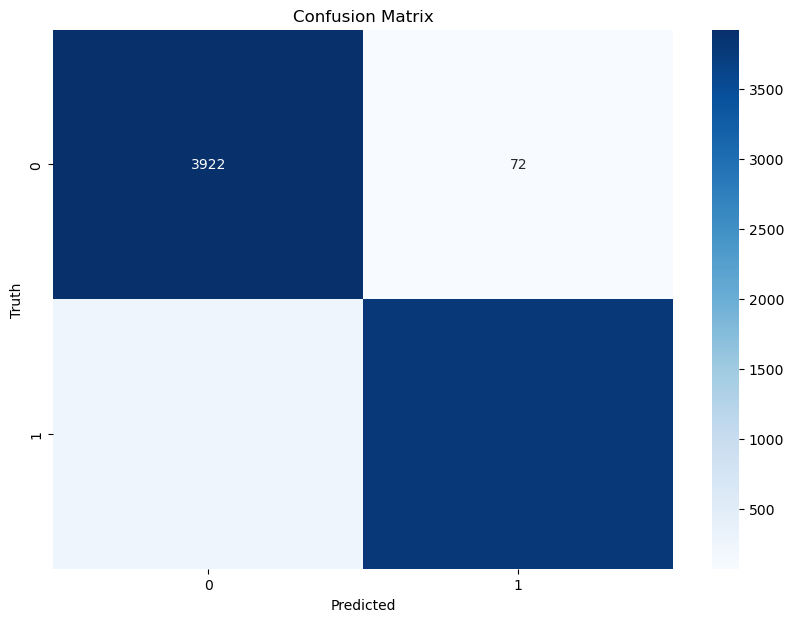

In [37]:
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
y_pred = CNN.predict(X_test)
y_pred_rounded = np.round(y_pred)
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rounded)
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [23]:
from sklearn.metrics import classification_report
# Print classification report
print(classification_report(y_test, y_pred_rounded, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.94      0.98      0.96      3994
    Positive       0.98      0.94      0.96      4044

    accuracy                           0.96      8038
   macro avg       0.96      0.96      0.96      8038
weighted avg       0.96      0.96      0.96      8038



In [24]:
# Save the entire model to a HDF5 file
CNN.save('CNN_sentiment_analysis.h5')


## VGG-16 architecture

In [25]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model

# Define the model
embedding_layer = Embedding(vocab_size, 100, input_length=max_length, trainable=False)
sequence_input = Input(shape=(max_length,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(64, 3, activation='relu', padding='same')(embedding_sequences)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x= MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

x = Conv1D(256, 3, activation='relu', padding='same')(x)
x = Conv1D(256, 3, activation='relu', padding='same')(x)
x = Conv1D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

x = Conv1D(512, 3, activation='relu', padding='same')(x)
x = Conv1D(512, 3, activation='relu', padding='same')(x)
x = Conv1D(512, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

x = Conv1D(512, 3, activation='relu', padding='same')(x)
x = Conv1D(512, 3, activation='relu', padding='same')(x)
x = Conv1D(512, 3, activation='relu', padding='same')(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model_vgg16 = Model(sequence_input, outputs)

# Compile the model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [26]:
history = model_vgg16.fit(X_train, y_train, batch_size=64, epochs=5)


Epoch 1/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 278s 545ms/step - accuracy: 0.4985 - loss: 0.6938
Epoch 2/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 226s 448ms/step - accuracy: 0.4979 - loss: 0.6932
Epoch 3/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 196s 390ms/step - accuracy: 0.5001 - loss: 0.6932
Epoch 4/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 300s 596ms/step - accuracy: 0.4955 - loss: 0.6932
Epoch 5/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 210s 417ms/step - accuracy: 0.4971 - loss: 0.6932


In [27]:
loss, accuracy = model_vgg16.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

252/252 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.4983 - loss: 0.6932
Test Loss: 0.6931823492050171
Test Accuracy: 0.49688977003097534


In [28]:
model_vgg16.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 77)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 77, 100)        │       608,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 77, 64)         │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 77, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 77, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 77, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 77, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 77, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 77, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 77, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 77, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 77, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 77, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 77, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 77, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 77, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 77, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 77, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 39424)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    20,185,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,733,817 (292.72 MB)

 Trainable params: 25,375,105 (96.80 MB)

 Non-trainable params: 608,500 (2.32 MB)

 Optimizer params: 50,750,212 (193.60 MB)

## Inception Architecture

In [29]:
# Define the model
sequence_input = Input(shape=(max_length,), dtype='int32')
# This defines the input layer of the model, where max_length is the length of the input sequences.

embedding_sequences = embedding_layer(sequence_input)
# Apply an embedding layer to the input sequences, convert them into dense vectors of fixed size

l1 = Conv1D(64, 1, activation='relu', padding='same')(embedding_sequences)
l2 = Conv1D(64, 3, activation='relu', padding='same')(embedding_sequences)
l3 = Conv1D(64, 5, activation='relu', padding='same')(embedding_sequences)
l4 = Conv1D(64, 7, activation='relu', padding='same')(embedding_sequences)
l5 = Conv1D(64, 9, activation='relu', padding='same')(embedding_sequences)
''' 
- 1D convolutional layers with different filter sizes (1, 3, 5, 7, and 9). Each layer has 64 filters and uses the ReLU activation function. 
- The padding='same' ensures that the output has the same length as the input.
'''

l6 = MaxPooling1D(pool_size=3, strides=1, padding='same')(embedding_sequences)
l6 = Conv1D(64, 1, activation='relu', padding='same')(l6)
'''
- This applies a max pooling layer with a pool size of 3 and stride of 1, 
followed by a 1D convolutional layer with 64 filters and a filter size of 1
'''

l = Concatenate(axis=-1)([l1, l2, l3, l4, l5, l6])
# This concatenates the outputs of all the convolutional layers along the last axis, combining their features.
l = Flatten()(l)
# This flattens the concatenated output into a 1D vector.
l = Dense(512, activation='relu')(l)
l = Dense(512, activation='relu')(l)
# These are two fully connected (dense) layers with 512 units each, using the ReLU activation function.

outputs = Dense(1, activation='sigmoid')(l)
# This is the output layer with a single unit and a sigmoid activation function, suitable for binary classification

model_inception = Model(sequence_input, outputs)
# Combines the input and output layers into a model.

model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Compile the model 


In [38]:
history = model_inception.fit(X_train, y_train, batch_size=512, epochs=20)
'''
This method trains the model on the training data: 
- X_train: The input data (features) for training.
- y_train: The target data (labels) for training.
- epochs=5: The number of times the entire training dataset will pass through the model. In this case, the model will be trained for  epochs.
- batch_size=batch_size: The number of samples per gradient update. Here, it uses the previously defined batch_size of 512.
'''


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.9897 - loss: 0.0301
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.9949 - loss: 0.0154
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.9969 - loss: 0.0102
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.9969 - loss: 0.0099
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.9967 - loss: 0.0101
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.9965 - loss: 0.0105
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.9968 - loss: 0.0090
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.9970 - loss: 0.0080
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.9964 - loss: 0.0081
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.9975 - loss: 0.0066
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.9974 - loss: 0.0066
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13

'\nThis method trains the model on the training data: \n- X_train: The input data (features) for training.\n- y_train: The target data (labels) for training.\n- epochs=5: The number of times the entire training dataset will pass through the model. In this case, the model will be trained for  epochs.\n- batch_size=batch_size: The number of samples per gradient update. Here, it uses the previously defined batch_size of 512.\n'

In [39]:
loss, accuracy = model_inception.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9530 - loss: 0.3290
Test Loss: 0.3411877751350403
Test Accuracy: 0.9543418884277344


252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


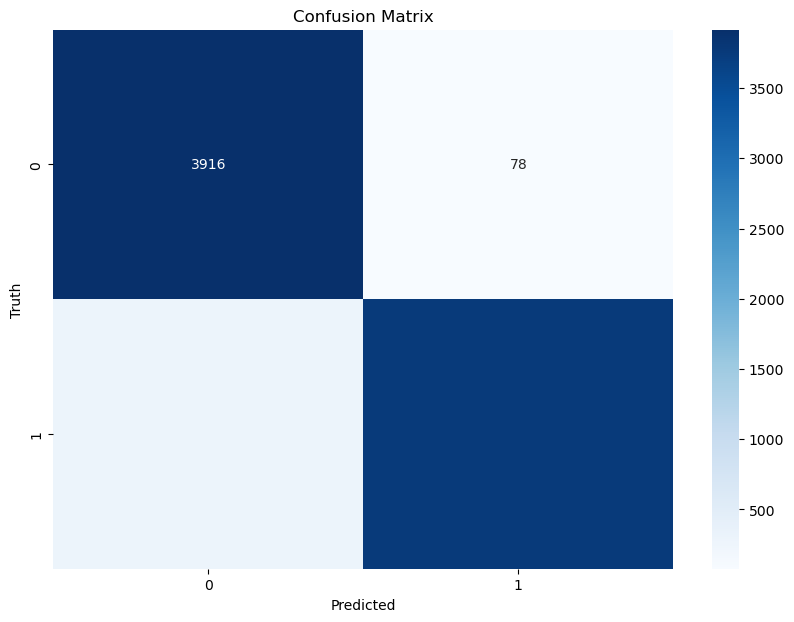

In [40]:
y_pred = model_inception.predict(X_test)
y_pred_rounded = np.round(y_pred)
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rounded)
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [41]:
# Print classification report
print(classification_report(y_test, y_pred_rounded, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.93      0.98      0.96      3994
    Positive       0.98      0.93      0.95      4044

    accuracy                           0.95      8038
   macro avg       0.96      0.95      0.95      8038
weighted avg       0.96      0.95      0.95      8038



In [42]:
def predict_sentiments(model, tokenizer, df1, num_samples=10):
    results = []
    for _ in range(num_samples):
        index = np.random.randint(0, len(df1))
        comment = df1.iloc[index]['comment']
        y_true = df1.iloc[index]['sentiment']
        sequence = tokenizer.texts_to_sequences([comment])
        padded_sequence = pad_sequences(sequence, maxlen=max_length)
        prediction = model.predict(padded_sequence)[0][0]
        sentiment = "Positive" if prediction >= 0.5 else "Negative"
        results.append((comment, sentiment, y_true))

    return results

results = predict_sentiments(CNN, tokenizer, df1, num_samples=30)
for i, (comment, sentiment, y_true) in enumerate(results, 1):
    print(f"Sample {i}:")
    print("comment:", comment)
    print("Predicted Sentiment:", sentiment)
    print("True Sentiment:", "Positive" if y_true == 1 else "Negative")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [43]:
results = predict_sentiments(model_inception, tokenizer, df1, num_samples=30)
for i, (comment, sentiment, y_true) in enumerate(results, 1):
    print(f"Sample {i}:")
    print("comment:", comment)
    print("Predicted Sentiment:", sentiment)
    print("True Sentiment:", "Positive" if y_true == 1 else "Negative")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [45]:
results1 = predict_sentiments(CNN, tokenizer, df1, num_samples=30)
for i, (comment, sentiment, y_true) in enumerate(results, 1):
    print(f"Sample {i}:")
    print("comment:", comment)
    print("Predicted Sentiment:", sentiment)
    print("True Sentiment:", "Positive" if y_true == 1 else "Negative")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [44]:
model_inception.save('inception_sentiment_analysis.h5')
